In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
import matplotlib.pylab as plt # Para gráficos

In [2]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # Accuracy metrics 

In [217]:
EXPORT_PATH = 'push-up-reload.csv'

In [218]:
df = pd.read_csv(EXPORT_PATH)
df['class'].value_counts()

1    4296
0    2730
Name: class, dtype: int64

In [219]:
X = df.drop('class', axis=1) # features
y = df['class'] # target

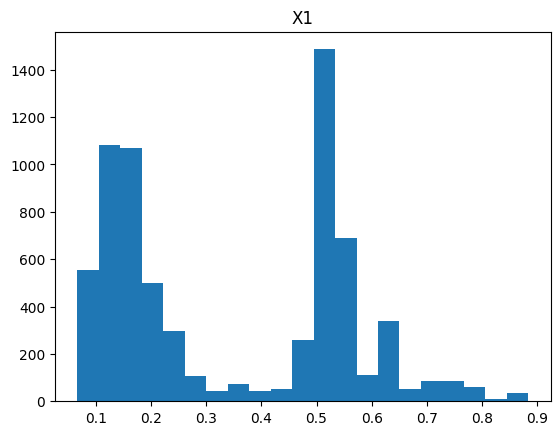

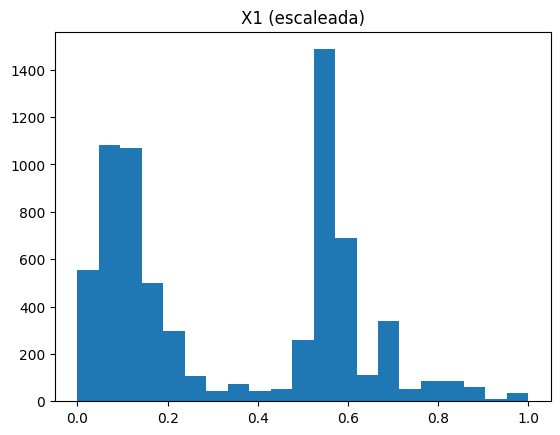

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X_scale = scaler.transform(X) # aplico la transformacion
plt.hist(X['x1'], bins='auto')  
plt.title("X1")
plt.show()


plt.hist(X_scale[:,0], bins='auto')  
plt.title("X1 (escaleada)")
plt.show()


In [40]:
from sklearn.model_selection import StratifiedKFold
# X_1 = X[:].values

In [ ]:
!pip install catboost

In [78]:
from catboost import CatBoostClassifier

In [101]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', class_weight='balanced', max_iter=20000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'cb':make_pipeline(StandardScaler(), CatBoostClassifier()),
}

In [220]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [222]:
X_= X_train.reset_index()
y_= y_train.reset_index()

In [223]:
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [226]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            scaler.fit(X_train_) # encuentro los parametros para el escaleo
            X_train_ = scaler.transform(X_train_) # aplico la transformacion

            scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            scaler.fit(X_test_) # encuentro los parametros para el escaleo
            X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label=1),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label=1),3)))
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),2)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),2)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),2)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')
      # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      # auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

      # auc_values.append(auc_test)
      # scores = np.concatenate((scores,probas_test[:,1]),axis=0)
      # indices = np.concatenate((indices,test_index),axis=0)
      fit_models[algo] = model


lr ac-sc: 0.767 pr-sc: 0.814 rc-sc: 0.767
lr ac-sc: 0.866 pr-sc: 0.868 rc-sc: 0.866
lr ac-sc: 0.684 pr-sc: 0.786 rc-sc: 0.684
lr ac-sc: 0.713 pr-sc: 0.801 rc-sc: 0.713
lr ac-sc: 0.419 pr-sc: 0.768 rc-sc: 0.419
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.69 precision_score 0.81 recall_score 0.69
----------------------------------------------------
----------------------------------------------------
rc ac-sc: 0.823 pr-sc: 0.849 rc-sc: 0.823
rc ac-sc: 0.63 pr-sc: 0.686 rc-sc: 0.63
rc ac-sc: 0.726 pr-sc: 0.807 rc-sc: 0.726
rc ac-sc: 0.803 pr-sc: 0.832 rc-sc: 0.803
rc ac-sc: 0.569 pr-sc: 0.776 rc-sc: 0.569
----------------------------------------------------
--------------PROMEDIOS--DE-- rc -------------------------
Accuracy 0.71 precision_score 0.79 recall_score 0.71
----------------------------------------------------
----------------------------------------------------
rf ac-sc: 0.975 pr-sc: 0.975 rc-sc: 0.97

In [228]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # Accuracy metrics 
import pickle 

In [229]:
MODEL_PATH_1 = 'flexiones_rf.pkl'
MODEL_PATH_2 = 'flexiones_gb.pkl'
MODEL_PATH_3 = 'flexiones_cb.pkl'

In [231]:
with open(MODEL_PATH_1, 'wb') as f:
    pickle.dump(fit_models['rf'], f)
    
with open(MODEL_PATH_2, 'wb') as f:
    pickle.dump(fit_models['gb'], f)

with open(MODEL_PATH_3, 'wb') as f:
    pickle.dump(fit_models['cb'], f)        

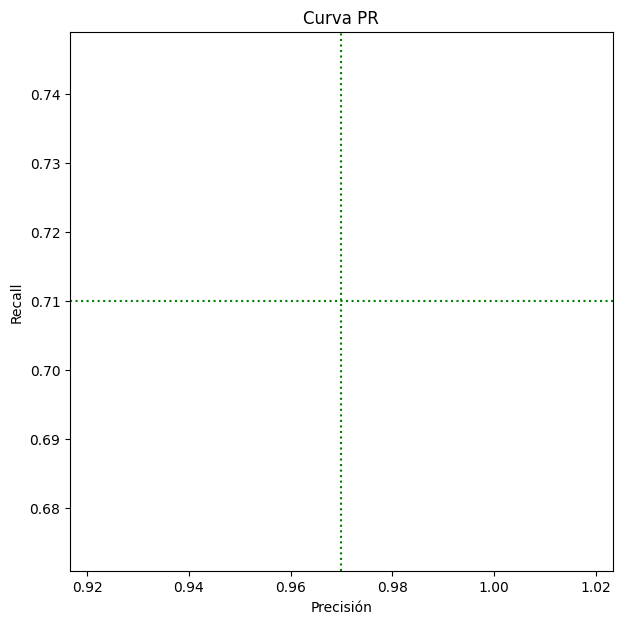

In [233]:
fig = plt.figure(figsize=(7, 7))
plt.plot(0.97, 0.71)
plt.axvline(0.97, ls=':', color='green')
plt.axhline(0.71, ls=':', color='green')
plt.xlabel('Precisión')
plt.ylabel('Recall')
plt.title('Curva PR')
plt.show()

In [ ]:
umb = np.linspace(y_scores.min()-1, y_scores.max()+1, 5000)

recall = np.zeros_like(umb)
precision = np.zeros_like(umb)
fpr = np.zeros_like(umb)

for i, u in enumerate(umb):
    
    # Calcula los índices con detecciones para este umbral
    det = y_scores > u
    
    # Compara esto con los verdaderos casos en esos índices

    tp = np.sum(t_train_1[det] == True)
    # Falsos positivos
    fp = np.sum(t_train_1[det] == False)

    # Verdaderos y falsos negativos
    tn = np.sum(t_train_1[~det] == False)
    fn = np.sum(t_train_1[~det] == True)
    
    recall[i] = tp/(tp + fn)
    precision[i] = tp/(tp + fp)
    fpr[i] = fp/(fp + tn)

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.plot(umb, precision, label='Precisión', lw=2)
plt.plot(umb, recall, label='Exhaustividad', lw=2)
plt.xlabel("Umbral", fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.xlim(-umb.max(), umb.max())
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))  